In [1]:
import cv2
import sys
import os
import matplotlib.pyplot as plt
import torch 
from skimage import io
import numpy as np
# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the Python path
sys.path.append(parent_dir)

In [2]:
def read_and_normalize(path):
    img = io.imread(path)
    img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

In [3]:
import importlib

In [4]:
device="cpu"

In [44]:
from boundary_aware import pfpn
from boundary_aware import siamese_unet
from baselines import siamese_unet as baseline_siamese_unet

In [6]:
def check_keys(model, pretrain_path):
    # Check for matching keys
    pretrain = torch.load(pretrain_path, map_location=torch.device('cpu'))
    pretrained_keys = set(pretrain.keys())
    model_keys = set(model.state_dict().keys())

    missing_keys = model_keys - pretrained_keys
    unexpected_keys = pretrained_keys - model_keys

    if len(missing_keys) > 0:
        print("Missing keys in Siamese network:", missing_keys)
    else: 
        print("No Missing keys")

    if len(unexpected_keys) > 0:
        print("Unexpected keys in pre-trained UNet:", unexpected_keys)
    else:
        print("No unexpected keys")

No Missing keys
No unexpected keys


ok


In [39]:
patient_id = "38"
instance= "0"
slc = 97
orig_dir = "/home/prateek/from_kipchoge/ms_project/change_balcrop256/"
# orig_dir = "/home/prateek/from_kipchoge/ms_project/open_ms_data/slice_data/"
# test_img1 = torch.from_numpy(read_and_normalize(os.path.join(orig_dir,"A",f"open_ms_{patient_id}_{instance}_{slc}.png")))
# test_img2 = torch.from_numpy(read_and_normalize(os.path.join(orig_dir,"B",f"open_ms_{patient_id}_{instance}_{slc}.png")))
test_img1 = torch.from_numpy(read_and_normalize(os.path.join(orig_dir,"A",f"test_sub-ID{patient_id}_{instance}_{slc}.png")))
test_img2 = torch.from_numpy(read_and_normalize(os.path.join(orig_dir,"B",f"test_sub-ID{patient_id}_{instance}_{slc}.png")))
labels = torch.from_numpy(read_and_normalize(os.path.join(orig_dir,"label",f"test_sub-ID{patient_id}_{instance}_{slc}.png")))
print(torch.sum(labels))

tensor(241.2275)


In [40]:
# apply preprocessing
x1 =  test_img1.unsqueeze(0).unsqueeze(0).requires_grad_(True).to(device)
x2 = test_img2.unsqueeze(0).unsqueeze(0).requires_grad_(True).to(device)
# Check the type of x1 and x2


In [57]:
model = siamese_unet.SiameseNetwork(1,1, aspp=False)
path = "../saved_models/siam_b_unet_f05_f05_pre.pt"
check_keys(model, path)
model.load_state_dict(torch.load('../saved_models/siam_b_unet_f05_f05_pre.pt', map_location=torch.device(device)), strict=False)
model.to(device)
print("ok")

No Missing keys
No unexpected keys
ok


In [33]:
ba_pfpn = pfpn.MultiTaskPFPN(2,1, mask_decoder=pfpn.AttentionPFPNDecoder,boundary_decoder=pfpn.AttentionPFPNDecoder)

In [34]:
ba_pfpn.load_state_dict(torch.load('../saved_models/ba_att_pfpn_bce_f05.pt', map_location=torch.device(device)), strict=False)
ba_pfpn.to(device)
print("ok")

ok


In [25]:
siam = baseline_siamese_unet.SiameseNetwork("unet",head_nw="concat")
params = torch.load("../saved_models/siamese_unet_c_f05.pt", map_location=torch.device(device))
siam.load_state_dict(params)
print("ok")

ok


In [46]:
from interpretability import cam
importlib.reload(cam)

<module 'interpretability.cam' from '/home/prateek/ms_change_detection/interpretability/cam.py'>

In [54]:
def show_cams(cams, image1, image2, prediction, labels):
    image1 = image1.squeeze().detach().cpu().numpy()
    image2 = image2.squeeze().detach().cpu().numpy()
    prediction = prediction.squeeze().detach().cpu().numpy()
    num_layers = len(cams)+1
    fig, axes = plt.subplots(num_layers, 2, figsize=(12, num_layers * 6))
    fig.suptitle("Grad-CAM Results", y=1)

    for idx, (name, (cam1, cam2)) in enumerate(cams):
        cam_image1 = cam.show_cam_on_image(image1, cam1)
        cam_image2 = cam.show_cam_on_image(image2, cam2)

        axes[idx, 0].imshow(cam_image1)
        axes[idx, 0].set_title(f"{name} - Image 1")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(cam_image2)
        axes[idx, 1].set_title(f"{name} - Image 2")
        axes[idx, 1].axis('off')
    axes[-1, 0].imshow(prediction)
    axes[-1, 0].set_title("Prediction")
    axes[-1, 0].axis('off')
    axes[-1, 1].imshow(labels, cmap='gray')
    axes[-1, 1].set_title("Ground Truth")
    axes[-1, 1].axis('off')
    plt.tight_layout(pad=0)
    plt.show()


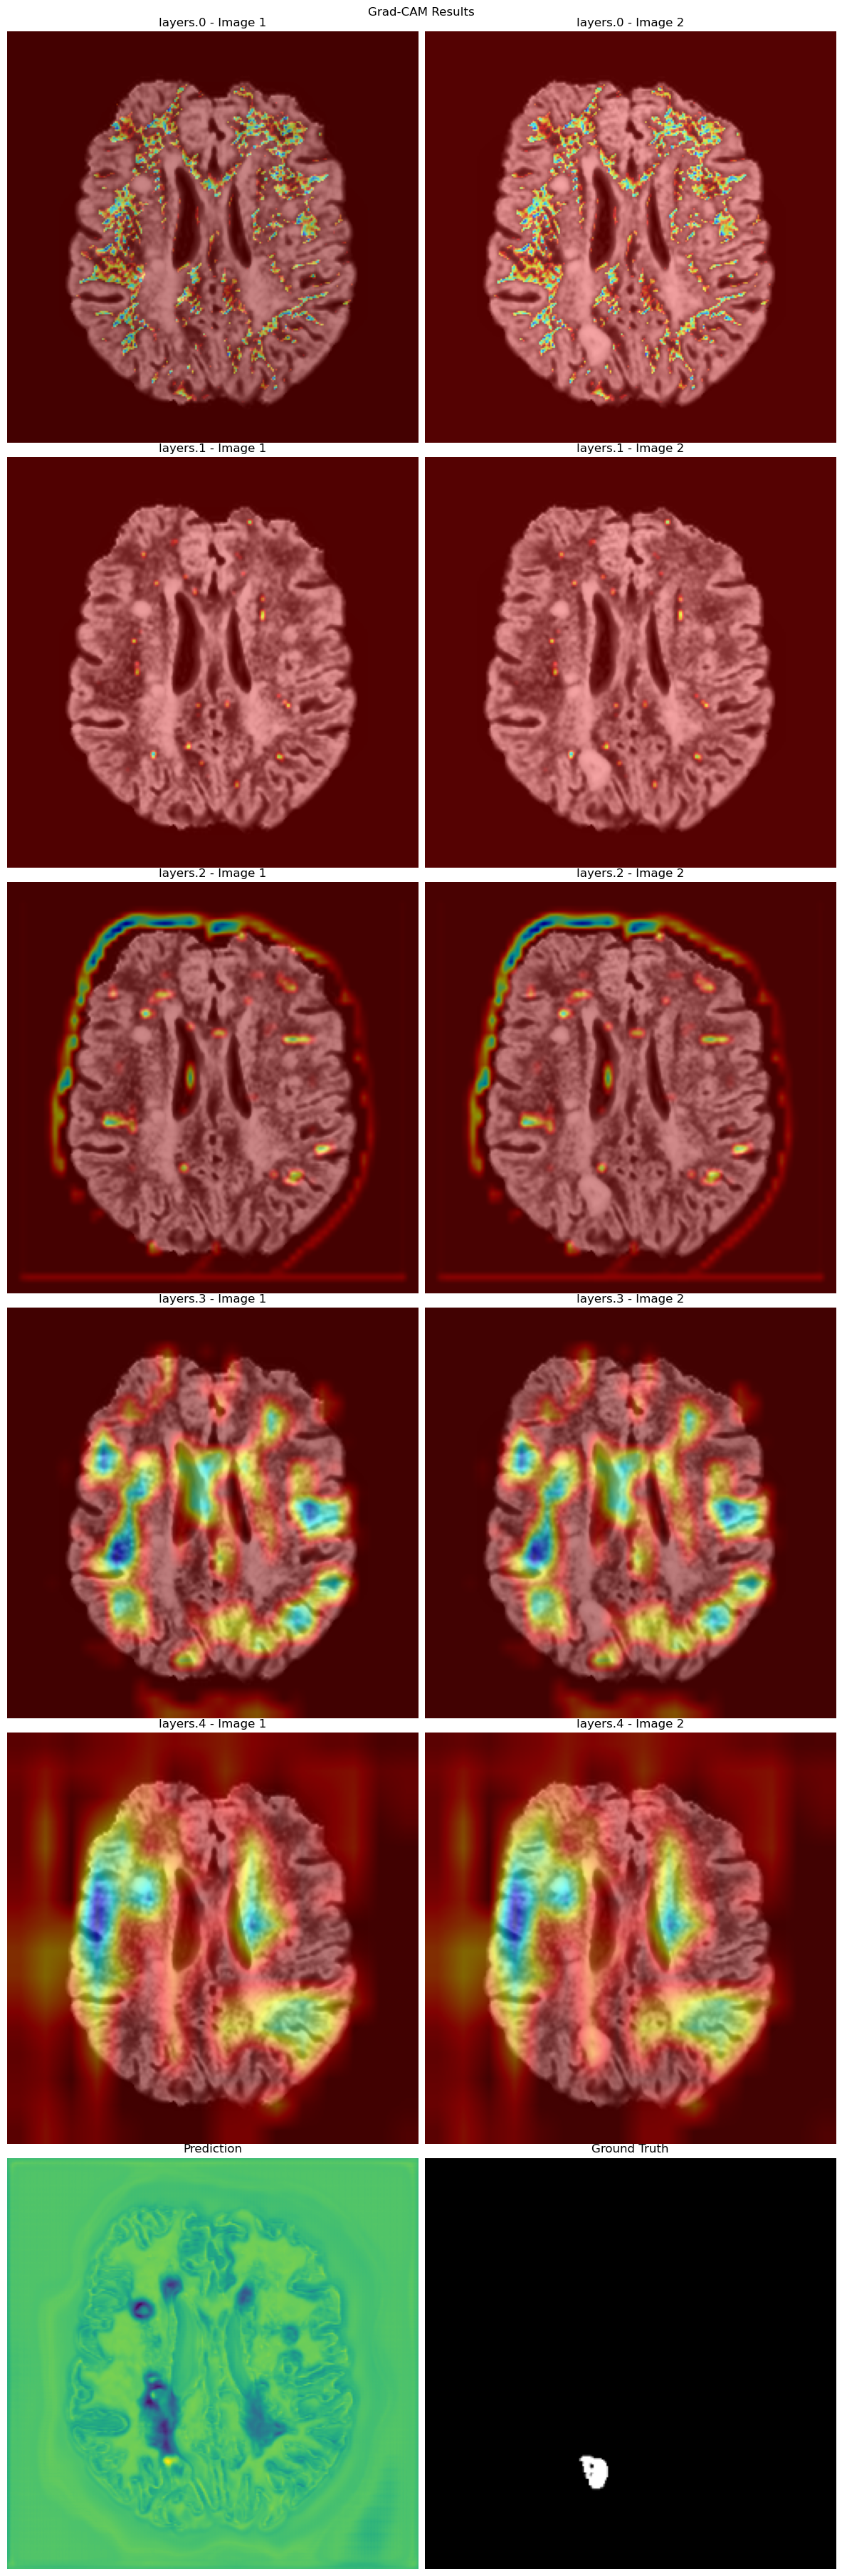

In [55]:
cams, pred = cam.GradCAM(siam, "siamese_unet", probe_encoder=True).generate_cam(x1, x2)
show_cams(cams, x1, x2, pred, labels)

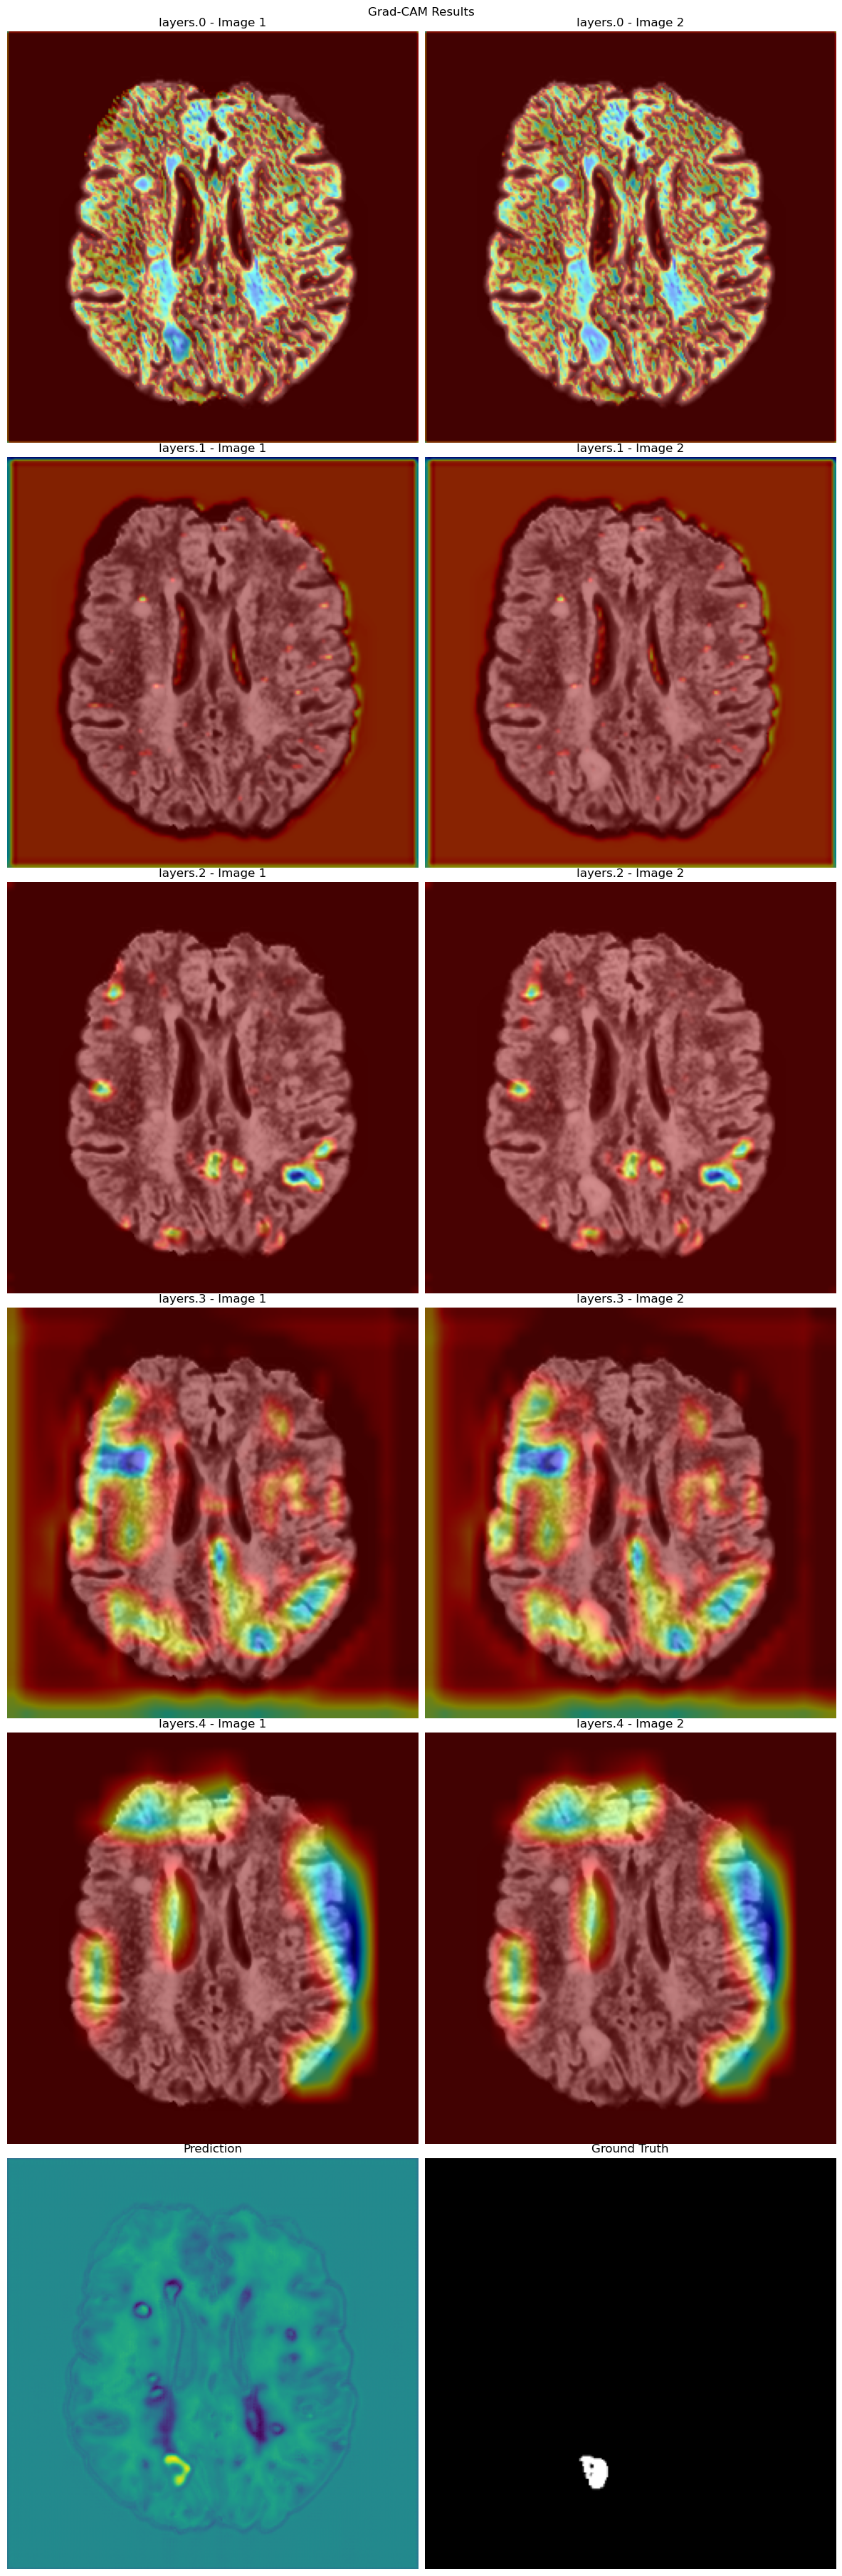

In [58]:
cams, pred = cam.GradCAM(model, model_name="boundary_aware", with_boundary=True, probe_encoder=True).generate_cam(x1, x2)
show_cams(cams, x1, x2, pred, labels)

In [ ]:
cams, pred = cam.GradCAM(ba_pfpn, model_name="boundary_aware", with_boundary=True, probe_encoder=True).generate_cam(x1, x2)
show_cams(cams, x1, x2, pred, labels)